### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [4]:
%%time
canary_p = '../../../data/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.63 s, sys: 6.98 s, total: 12.6 s
Wall time: 12.5 s


In [5]:
pmpm.MEDICAID_LOB.unique()

array(['Medicare', 'Commercial', 'Other', 'ASO', 'Medicaid-HARP',
       'Medicaid-TANF', 'Medicaid-SSI', 'Medicaid-CHP', 'Medicaid-Other'],
      dtype=object)

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [6]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [7]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [8]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 12.2 s, sys: 7.53 s, total: 19.7 s
Wall time: 19.7 s


In [9]:
from utils import ip_er2

In [10]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)
#pmpm['ACUTE'] =  ((pmpm.IP_BIN>0) | (pmpm.ER_BIN > 0 )).astype(int)

CPU times: user 7.17 s, sys: 2.72 s, total: 9.9 s
Wall time: 9.89 s


In [11]:
%%time
pmpm[['IP_C', 'ER_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN6', 'ER_BIN6']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C']]).reset_index(drop = True)
#pmpm[['IP_BIN2', 'ER_BIN2','ACUTE2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C','ACUTE_C']].diff(2).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)

CPU times: user 1min 48s, sys: 4.13 s, total: 1min 52s
Wall time: 1min 49s


%%time
pmpm = pmpm.groupby('PERS_ID', sort = False).apply(ip_er2, time = 6).reset_index(drop = True)

In [12]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2      -3  201910        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3      -3  201911 

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [13]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 9.15 s, sys: 5.66 s, total: 14.8 s
Wall time: 14.8 s


Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [14]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 5.68 s, sys: 26 ms, total: 5.71 s
Wall time: 5.71 s


In [15]:
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN6', 'ER_BIN6','LOB']

#### Visualization of the clusters created in the previous step with a clustermap

In [16]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
hier_cols = ['CC_DX_CNT', 'IP_BIN6', 'ER_BIN6']
hier_range = [1,1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" = 1}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)
"""


Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:315659 before they were:342223
IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None
There were no matches for 4 out of 1547 patients
CPU times: user 48min 50s, sys: 28min 30s, total: 1h 17min 21s
Wall time: 1h 17min 21s


'\n#columns_to_match = columns_to_match + [\'IP_BIN2\', \'ER_BIN2\']\npropensity_func_args = {\'match_on\':columns_to_match, \'neighbors_per_treated\': 5, \'onset\': "CC_DIABETES", "onset_val" = 1}\nmatched0, matched_data0 = matched_population(treated2.copy(), \n                                           controls.copy(),\n                                           propensity_func, \n                                           propensity_func_args)\n'

####  In addition to the previously created matched groups create a random group

In [17]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


In [18]:
Path('./tempNN').mkdir(exist_ok = True)
p = './tempNN/'
matched_data0.to_pickle(p+'match0.p')
random_controls.to_pickle(p+'random.p')
treated2.to_pickle(p+'treated0.p')
pmpm.to_pickle(p+'pmpm.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [19]:
%%time
con_onset0 = diabet_onset(matched_data0.copy(), 'Diabetes_Con0')

treated_onset0 = diabet_onset(treated2.copy(), 'Diabetes_Tr')

pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 4min 21s, sys: 23.7 s, total: 4min 45s
Wall time: 4min 42s


In [20]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [21]:
con_onset20 = con_onset0.rename(columns = {'Sample': 'Sample_Con0', 'Per_1000':'Per_1000_Con0'})

treated_onset20 = treated_onset0.rename(columns = {'Sample': 'Sample_Tr0', 'Per_1000':'Per_1000_Tr0'})

pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [22]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset20, treated_onset20,  pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month Statistics

1. **_Con{i} : For Matched Controls Population**
2.  **_Tr{i} : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

>Sample_: The number of patients per month  
Diabetes_: The number of patients with Diabetes Onset in a month  
Per_1000_: The number of patients with Diabetes Onset in a a month per 1000  


In [23]:
joint.describe().loc[['mean', 'std']]

Sample_Con0  Diabetes_Con0  Per_1000_Con0  Sample_Tr0  Diabetes_Tr  Per_1000_Tr0      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  2066.785714       3.761905       1.649395  467.976190     1.000000      1.514532  143003.882353   279.901961     1.961085  31923.976190     56.928571     1.663965
std   1959.379538       3.759927       1.660111  451.932894     1.343457      2.622293   13718.389511    44.775554     0.272818  28098.759468     50.682846     0.660305

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [25]:
joint2 = pd.concat((con_onset0,  treated_onset0,   pmpm_onset, random_onset), axis = 1)
jointcon0 = joint2.Per_1000.iloc[1:, 0].reset_index()
jointTr0 = joint2.Per_1000.iloc[1:, 1].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 2].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 3].reset_index()


<div style="background:Aliceblue"> 
    <h3> Plot Top Left: $f(x)$ = Onset Per 1000 per month </h3>
    <h3> Plot Top Right and Bottom Left: $F(x) = \int_0^x f(y)dy$ <br>
        Cumulative sum of the rates </h3>
</div>

No handles with labels found to put in legend.


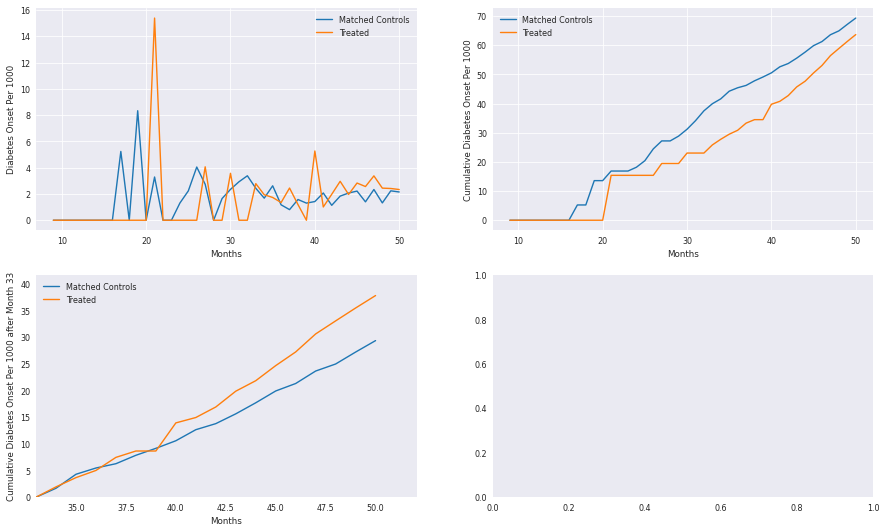

In [26]:
from diabetes_onset_plotter import  plot_onset2
names = ['Matched Controls', 'Treated']#, 'Random']
f, ax = plot_onset2(jointcon0, jointTr0, names = names)
#f.savefig('figs/onset.png')
plt.show()

In [27]:
a = treated2.groupby(['PERS_ID']).apply(lambda x: pd.Series([x.MBR_GNDR.sum(), len(x)], index = ['GEN', 'LEN'])).reset_index(drop = True)

In [28]:
from utils import statistics_first_month

In [29]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [30]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 2min 43s, sys: 4.17 s, total: 2min 47s
Wall time: 2min 47s


In [31]:
import scipy.stats as sts

In [32]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [33]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

## Statistics on matching date

In [34]:
alli

Treated Matched Controls    T-Test           Genaral Population      Random
                       mean             mean    t-stat      pval               mean        mean
AGE_AT_MIDMONTH   50.080802        50.166781 -0.239282  0.810892          43.048583   47.226057
ALLOW_AMT        667.881707       562.799698  1.686122  0.091808         986.578600  744.961151
MBR_GNDR           0.205559         0.210743 -0.454705  0.649333           0.432864    0.425249
CC_TOBACCO         0.062056         0.047122  2.454114  0.014142           0.072285    0.096863
CC_PRESSURE        0.001293         0.000824  0.556076  0.578173           0.003787    0.006119
CC_OBESITY         0.450549         0.415167  2.560165  0.010479           0.092396    0.220582
LOB                0.953458         0.953977 -0.088361  0.929592           0.752927    0.786264
CC_HYPERTENSION    0.323853         0.300453  1.816222  0.069370           0.174132    0.245921
CC_HYPOTHYROID     0.091791         0.058799  4.800173  0.000002           0.041370    0.063071
CC_DX_CNT          2.638009         2.555296  1.416826  0.156569           1.531662    2.304953
IP_BIN6            0.025210         0.017035  1.969762  0.048897           0.018782    0.045331
ER_BIN6            0.083387         0.076796  0.775920  0.437817           0.047123    0.121031

In [35]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [36]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [37]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated              Matched Controls                     T-Test Genaral Population      Random
                       mean          std             mean          std          pval               mean        mean
AGE_AT_MIDMONTH   50.496323    12.457383        50.799129    12.478709  1.348920e-03          48.759167   49.864087
ALLOW_AMT        763.316672  3997.354069       726.279276  3966.378480  2.181950e-01         748.531555  732.842437
MBR_GNDR           0.186865     0.389812         0.192336     0.394138  6.623759e-02           0.421103    0.419813
CC_TOBACCO         0.065255     0.246981         0.058982     0.235592  4.923296e-04           0.099304    0.104231
CC_PRESSURE        0.002249     0.047367         0.002646     0.051368  3.005951e-01           0.007168    0.007344
CC_OBESITY         0.500351     0.500012         0.445060     0.496975  1.024322e-48           0.231656    0.275515
LOB                0.955263     0.206731         0.948126     0.221774  1.696344e-05           0.797746    0.804567
CC_HYPERTENSION    0.321169     0.466937         0.315118     0.464565  8.571413e-02           0.283097    0.292906
CC_HYPOTHYROID     0.092706     0.290027         0.074058     0.261866  3.163731e-20           0.069572    0.073955
CC_DX_CNT          2.819600     2.191740         2.788756     2.152367  5.929299e-02           2.539357    2.719952
IP_BIN6            0.023704     0.162549         0.027738     0.185307  3.310451e-03           0.047520    0.046935
ER_BIN6            0.077622     0.354753         0.078131     0.308117  8.321368e-01           0.118977    0.113510

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [57]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 'Line of Bussiness'
                                     'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits']))
new_names = list(mapping.values())

In [58]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [59]:
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [60]:
from diabetes_onset_plotter import plot_hist


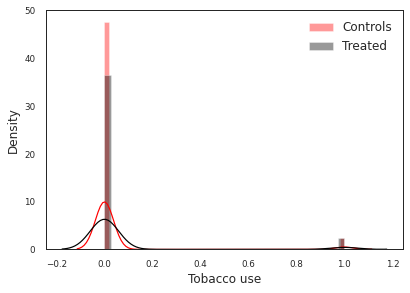

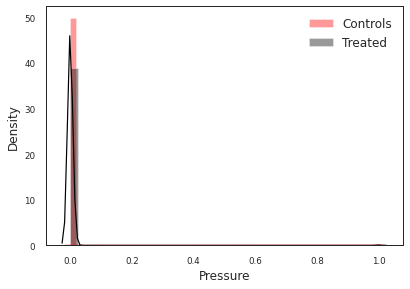

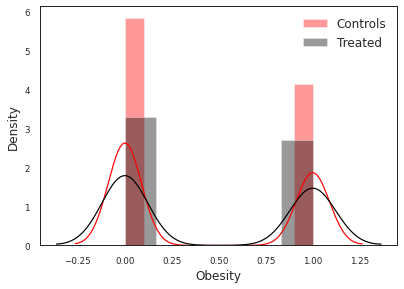

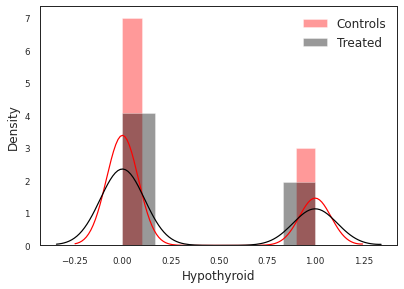

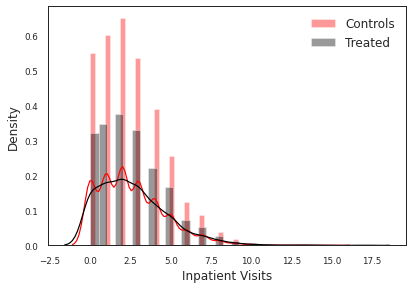

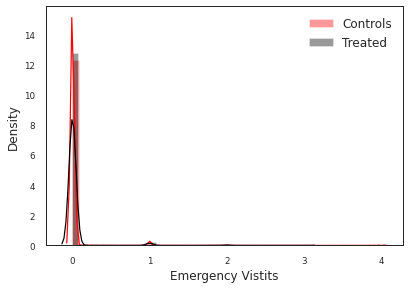

In [61]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [62]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

ValueError: Length mismatch: Expected axis has 12 elements, new values have 11 elements

In [63]:
all_paper


Treated  Matched Controls  T-Statistic  p-value  General Population  Random Match  Difference
Age                 50.081            50.167       -0.239    0.811              43.049        47.226      -0.086
Total Cost         667.882           562.800        1.686    0.092             986.579       744.961     105.082
Gender               0.206             0.211       -0.455    0.649               0.433         0.425      -0.005
Tobacco use          0.062             0.047        2.454    0.014               0.072         0.097       0.015
Pressure             0.001             0.001        0.556    0.578               0.004         0.006       0.000
Obesity              0.451             0.415        2.560    0.010               0.092         0.221       0.036
Hypertension         0.953             0.954       -0.088    0.930               0.753         0.786      -0.001
Hypothyroid          0.324             0.300        1.816    0.069               0.174         0.246       0.024
Disease Count        0.092             0.059        4.800    0.000               0.041         0.063       0.033
Inpatient Visits     2.638             2.555        1.417    0.157               1.532         2.305       0.083
Emergency Vistits    0.025             0.017        1.970    0.049               0.019         0.045       0.008
Line of Bussiness    0.083             0.077        0.776    0.438               0.047         0.121       0.006

In [55]:
only_means

Treated  Matched Controls  General Population  Random Match
Age                 50.081            50.167              43.049        47.226
Total Cost         667.882           562.800             986.579       744.961
Gender               0.206             0.211               0.433         0.425
Tobacco use          0.062             0.047               0.072         0.097
Pressure             0.001             0.001               0.004         0.006
Obesity              0.451             0.415               0.092         0.221
Hypertension         0.953             0.954               0.753         0.786
Hypothyroid          0.324             0.300               0.174         0.246
Disease Count        0.092             0.059               0.041         0.063
Inpatient Visits     2.638             2.555               1.532         2.305
Emergency Vistits    0.025             0.017               0.019         0.045
Line of Bussiness    0.083             0.077               0.047         0.121

In [ ]:
only_stats